# Installs & Imports

In [1]:
# Install packages
# !pip install pandas numpy matplotlib seaborn scipy scikit-learn openpyxl

In [2]:
# Import packages
# File handling
import os

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats

# Scikit-learn: Model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, QuantileTransformer
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    RidgeCV, LassoCV, ElasticNetCV
)
from sklearn.dummy import DummyRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Utility Functions

In [3]:
def plot_distribution_analysis(df, target_col='Quote'):
    """Plot target distribution with regulatory thresholds"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histogram with regulatory thresholds
    ax1.hist(df[target_col], bins=50, alpha=0.7, density=True, color='skyblue')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Insolvency')
    ax1.axvline(x=1, color='orange', linestyle='--', alpha=0.8, label='Undercapitalized')
    ax1.axvline(x=2, color='green', linestyle='--', alpha=0.8, label='Well-Capitalized')
    ax1.set_xlabel(target_col)
    ax1.set_ylabel('Density')
    ax1.set_title(f'{target_col} Distribution with Regulatory Thresholds')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot
    ax2.boxplot(df[target_col])
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.8)
    ax2.axhline(y=2, color='green', linestyle='--', alpha=0.8)
    ax2.set_ylabel(target_col)
    ax2.set_title(f'{target_col} Box Plot')
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Q plot
    from scipy import stats
    stats.probplot(df[target_col], dist="norm", plot=ax3)
    ax3.set_title(f'{target_col} Q-Q Plot (Normal Distribution)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Regulatory status pie chart
    if target_col == 'Quote':
        status_counts = df['regulatory_status'].value_counts()
        ax4.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
                colors=['red', 'orange', 'yellow', 'green'])
        ax4.set_title('Regulatory Status Distribution')
    else:
        # For other targets, show basic stats
        ax4.text(0.1, 0.8, f'Mean: {df[target_col].mean():.2e}', transform=ax4.transAxes)
        ax4.text(0.1, 0.7, f'Std: {df[target_col].std():.2e}', transform=ax4.transAxes)
        ax4.text(0.1, 0.6, f'Skewness: {df[target_col].skew():.3f}', transform=ax4.transAxes)
        ax4.text(0.1, 0.5, f'Kurtosis: {df[target_col].kurtosis():.3f}', transform=ax4.transAxes)
        ax4.set_title(f'{target_col} Statistics')
        ax4.axis('off')
    
    plt.tight_layout()
    return fig


In [4]:
def huber_loss(y_true, y_pred, delta=1.0):
    """Calculate Huber loss manually for comparison"""
    error = y_true - y_pred
    is_small = np.abs(error) <= delta
    loss = np.where(is_small, 0.5 * error**2, delta * (np.abs(error) - 0.5 * delta))
    return np.mean(loss)


def calculate_all_metrics(y_true, y_pred, prefix=""):
    """Calculate comprehensive regression metrics including regulatory context"""
    metrics = {
        f'{prefix}RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        f'{prefix}MAE': mean_absolute_error(y_true, y_pred),
        f'{prefix}R2': r2_score(y_true, y_pred),
        f'{prefix}Huber': huber_loss(y_true, y_pred),
        f'{prefix}MSE': mean_squared_error(y_true, y_pred)
    }
    
    # Add regulatory classification metrics for Quote predictions
    if isinstance(y_true, (pd.Series, np.ndarray)):
        # Regulatory threshold classification accuracy
        true_insolvent = (y_true < 0)
        pred_insolvent = (y_pred < 0)
        true_undercap = (y_true < 1)
        pred_undercap = (y_pred < 1)
        true_wellcap = (y_true > 2)
        pred_wellcap = (y_pred > 2)
        
        if len(y_true) > 0:
            metrics[f'{prefix}Insolvent_Accuracy'] = np.mean(true_insolvent == pred_insolvent)
            metrics[f'{prefix}Undercap_Accuracy'] = np.mean(true_undercap == pred_undercap)
            metrics[f'{prefix}WellCap_Accuracy'] = np.mean(true_wellcap == pred_wellcap)
            
            # MAPE for non-zero values (avoid division by zero)
            nonzero_mask = y_true != 0
            if np.sum(nonzero_mask) > 0:
                mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100
                metrics[f'{prefix}MAPE'] = mape
    
    return metrics


In [5]:
def analyze_regulatory_performance(y_true, y_pred, target_name="Quote"):
    """Analyze model performance across regulatory categories"""
    
    # Define regulatory categories
    categories = {
        'Insolvent': y_true < 0,
        'Undercapitalized': (y_true >= 0) & (y_true < 1),
        'Adequate': (y_true >= 1) & (y_true <= 2),
        'Well-Capitalized': y_true > 2
    }
    
    print(f"\nREGULATORY PERFORMANCE ANALYSIS - {target_name}")
    
    results = {}
    for category, mask in categories.items():
        if np.sum(mask) > 0:
            y_true_cat = y_true[mask]
            y_pred_cat = y_pred[mask]
            
            rmse = np.sqrt(mean_squared_error(y_true_cat, y_pred_cat))
            mae = mean_absolute_error(y_true_cat, y_pred_cat)
            r2 = r2_score(y_true_cat, y_pred_cat)
            
            results[category] = {
                'count': np.sum(mask),
                'percentage': np.sum(mask) / len(y_true) * 100,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            }
            
            print(f"\n{category} ({np.sum(mask)} obs, {np.sum(mask)/len(y_true)*100:.1f}%):")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  R²: {r2:.4f}")
    
    return results


# SECTION 1: Data Cleaning & Data Exploration

In [6]:
# Load the header row to see the column names
df_preview = pd.read_excel("BDSII Daten 2 - Original.xlsx",
                        sheet_name = "Tabelle1",
                        nrows = 0)

print(df_preview.columns.tolist())

['Nr.', 'ZSK1', 'ZSK2', 'ZSK3', 'Vola4', 'Vola5', 'Vola6', 'Verlust7', 'Verlust8', 'MR9', 'MR10', 'MR11', 'MR12', 'MR13', 'MR14', 'MR15', 'MR16', 'MR17', 'MR18', 'MR19', 'MR20', 'GCR', 'SF', 'VT', 'EM', 'SCR', 'Quote', 'SCR_Sterblichkeit', 'SCR_Langlebigkeit', 'SCR_Invalidität/Morbidität', 'SCR_Kosten', 'SCR_Stornoanstieg', 'SCR_Stornor\x81ückgang', 'SCR_Massenstorno', 'SCR_Katastrophe', 'SCR_Zinsrü\x81ckgang', 'SCR_Zinsanstieg', 'SCR_Zins', 'SCR_Aktien - sonstige', 'SCR_Aktien', 'SCR_Spread - Kreditderivate', 'SCR_Spread - Verbriefungen', 'SCR_Spread', 'SCR_Währung', 'SCR_Storno', 'SCR_Ausfall', 'SCR_vt. Risiko Leben', 'SCR_Marktrisiko', 'SCR_KV - Invalidität/Morbidität-Krankenkosten', 'SCR_KV - Storno', 'SCR_KV - Invalidität/Morbidität', 'SCR_vt. Risiko Kranken Leben', 'SCR_vt. Risiko Kranken']


In [7]:
# Read the sheet 
df = pd.read_excel("BDSII Daten 2 - Original.xlsx", sheet_name = "Tabelle1")

# The columns we do not need
cols_to_drop = [
    "GCR",
    "SF",
    "VT",
    "SCR_Sterblichkeit",
    "SCR_Langlebigkeit",
    "SCR_Invalidität/Morbidität",
    "SCR_Kosten",
    "SCR_Stornoanstieg",
    "SCR_Stornorückgang",   
    "SCR_Stornorückgang", 
    "SCR_Zinsrückgang",
    "SCR_Massenstorno",
    "SCR_Katastrophe",
    "SCR_Zinsrückgang",
    "SCR_Zinsanstieg",
    "SCR_Zins",
    "SCR_Aktien - sonstige",
    "SCR_Aktien",
    "SCR_Spread - Kreditderivate",
    "SCR_Spread - Verbriefungen",
    "SCR_Spread",
    "SCR_Währung",
    "SCR_Storno",
    "SCR_Ausfall",
    "SCR_vt. Risiko Leben",
    "SCR_Marktrisiko",
    "SCR_KV - Invalidität/Morbidität-Krankenkosten",
    "SCR_KV - Storno",
    "SCR_KV - Invalidität/Morbidität",
    "SCR_vt. Risiko Kranken Leben",
    "SCR_vt. Risiko Kranken"
]

# Drop the columns
df = df.drop(columns = cols_to_drop, errors = "ignore")

# Save the cleaned data to a csv file
df.to_csv("BDSII_Daten_2_clean.csv", index = False, encoding = "utf-8")

## SECTION 1.1: Exploratory Data Analysis (EDA)

In [8]:
# Set random seed for reproducibility
np.random.seed(8)

# Load the dataset
df = pd.read_csv("BDSII_Daten_2_clean.csv")

# Define feature columns and targets 
feature_cols = [col for col in df.columns if col not in ['Nr.', 'Quote', 'SCR', 'EM']]
target_cols = ['EM', 'SCR', 'Quote']

# Drop 'Nr.' because it's just an index
if 'Nr.' in df.columns:
    df = df.drop('Nr.', axis=1)


# Print shape and first 5 rows
print(f"Dataset shape: {df.shape}")
print(f"Features: {len(feature_cols)} columns")
# print(feature_cols)
print(f"\nFirst 5 rows:\n{df.head()}")

# Verify Quote calculation
print(f"\nQuote validation (should be ~0): {(df['Quote'] - df['EM']/df['SCR']).abs().max():.6f}")


Dataset shape: (10230, 23)
Features: 20 columns

First 5 rows:
       ZSK1      ZSK2      ZSK3     Vola4     Vola5     Vola6  Verlust7  \
0  0.922054  0.837028  0.809331  0.178250  0.901512  0.179174  0.191340   
1  0.619457  0.135444  0.742208  0.895245  0.203651  0.913381  0.066844   
2  0.527813  0.066627  0.979909  0.088391  0.905464  0.964193  0.445658   
3  0.471844  0.922035  0.351186  0.162060  0.121955  0.002218  0.269084   
4  0.940594  0.515785  0.569936  0.505810  0.090705  0.095968  0.987834   

   Verlust8   MR9  MR10  ...      MR14  MR15    MR16  MR17  MR18  MR19  MR20  \
0  0.056881  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
1  0.195996  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
2  0.465802  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
3  0.183026  0.25  0.25  ...  0.222222  0.35  0.4825  0.38  1.00     1   0.6   
4  0.026776  0.20  0.10  ...  0.888889  0.10  0.0305  0.10  0.06     1   0.7   

     

In [9]:
# Summary statistics for all targets
print(f"\nTARGET VARIABLES SUMMARY:")
for target in target_cols:
    print(f"\n\t {target}:")
    print(f"\t\t Mean: {df[target].mean():.2f}, Std: {df[target].std():.2f}")
    print(f"\t\t Min: {df[target].min():.2f}, Max: {df[target].max():.2f}")
    print(f"\t\t Median: {df[target].median():.2f}")

print(f"\nQUOTE DISTRIBUTION ANALYSIS: ")
print(f"Negative Quotes (insolvent): {(df['Quote'] < 0).sum()} ({(df['Quote'] < 0).mean()*100:.1f}%)")
print(f"Quote < 1 (undercapitalized): {(df['Quote'] < 1).sum()} ({(df['Quote'] < 1).mean()*100:.1f}%)")
print(f"Quote 1-2 (adequate): {((df['Quote'] >= 1) & (df['Quote'] < 2)).sum()} ({((df['Quote'] >= 1) & (df['Quote'] < 2)).mean()*100:.1f}%)")
print(f"Quote > 2 (well-capitalized): {(df['Quote'] >= 2).sum()} ({(df['Quote'] >= 2).mean()*100:.1f}%)")

# Check for insolvent scenarios (EM < 0)
print(f"\nSOLVENCY STATUS:")
print(f"Negative EM (insolvent entities): {(df['EM'] < 0).sum()} ({(df['EM'] < 0).mean()*100:.1f}%)")
print(f"Min EM: {df['EM'].min():.2e}, Max EM: {df['EM'].max():.2e}")

# Check for missing values
print(f"\nMISSING VALUES COUNT:")
missing_counts = df[feature_cols + target_cols].isnull().sum()
print(missing_counts[missing_counts > 0] if missing_counts.any() else "No missing values found")



TARGET VARIABLES SUMMARY:

	 EM:
		 Mean: 1114671387.37, Std: 433682060.51
		 Min: -4740847371.09, Max: 2109556898.96
		 Median: 1180780200.16

	 SCR:
		 Mean: 633980325.14, Std: 293138588.69
		 Min: 224202772.87, Max: 2149266315.21
		 Median: 505468137.09

	 Quote:
		 Mean: 2.17, Std: 1.01
		 Min: -2.47, Max: 4.65
		 Median: 2.43

QUOTE DISTRIBUTION ANALYSIS: 
Negative Quotes (insolvent): 272 (2.7%)
Quote < 1 (undercapitalized): 1654 (16.2%)
Quote 1-2 (adequate): 2077 (20.3%)
Quote > 2 (well-capitalized): 6499 (63.5%)

SOLVENCY STATUS:
Negative EM (insolvent entities): 272 (2.7%)
Min EM: -4.74e+09, Max EM: 2.11e+09

MISSING VALUES COUNT:
No missing values found


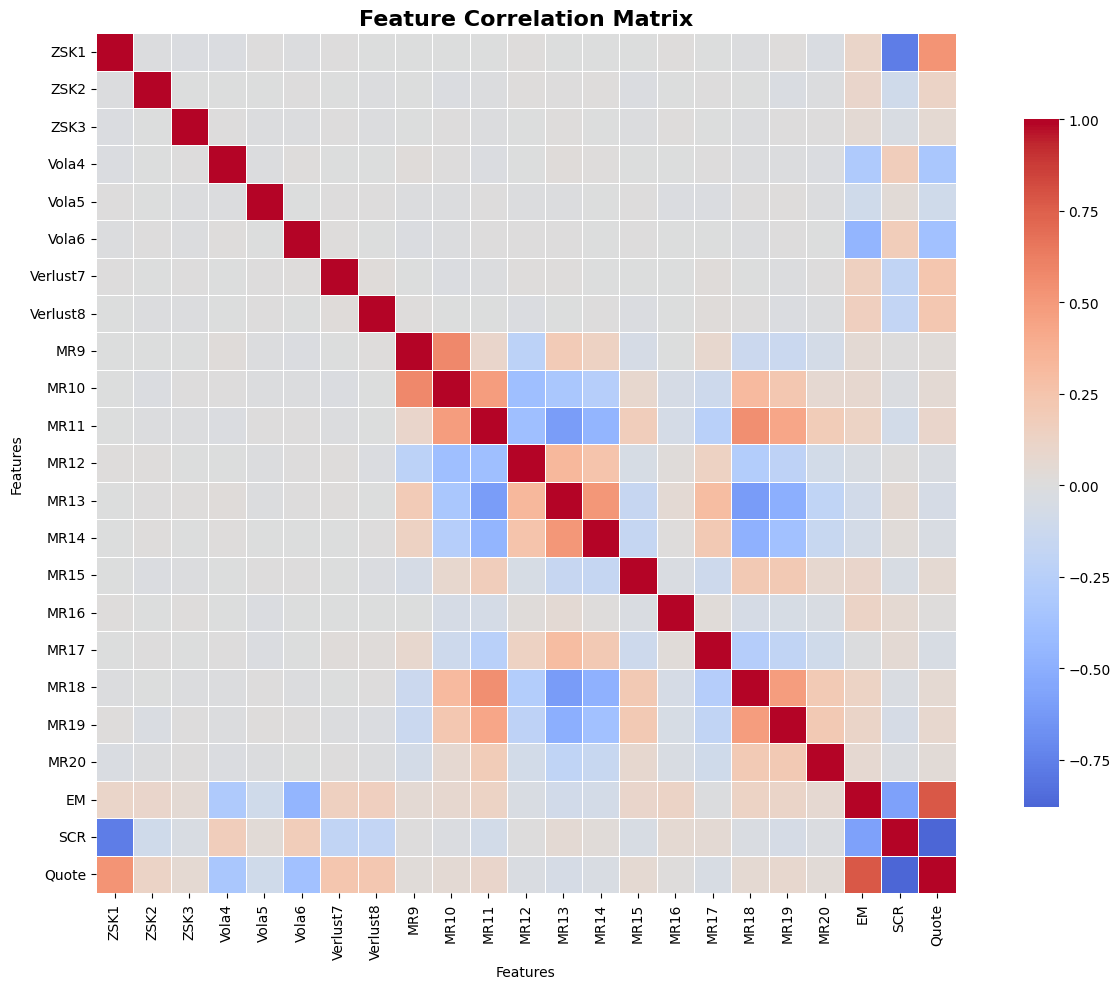

In [10]:
# Correlation matrix heatmap for all features
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

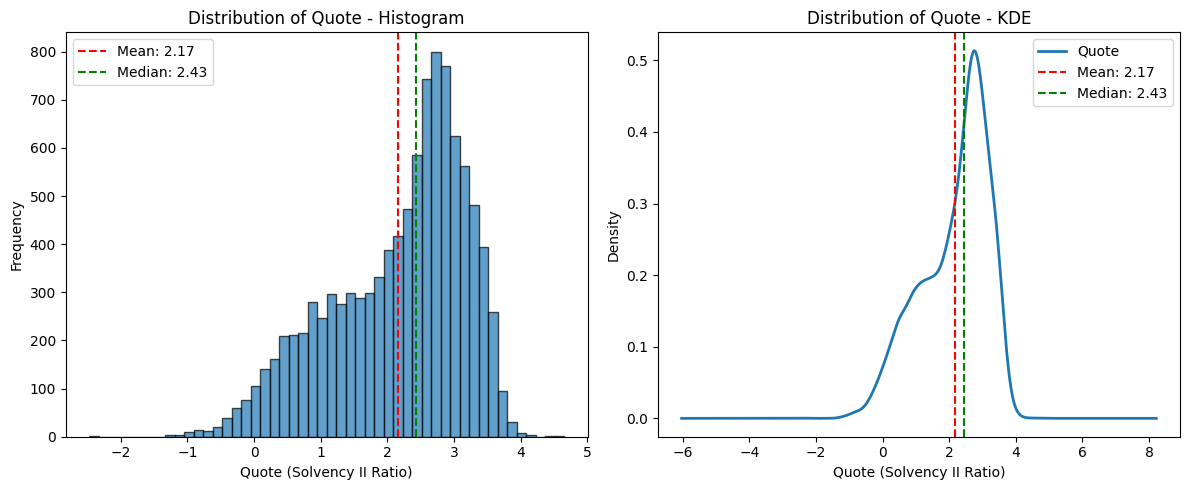

In [11]:
# Histogram/KDE of Quote
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Quote'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Quote (Solvency II Ratio)')
plt.ylabel('Frequency')
plt.title('Distribution of Quote - Histogram')
plt.axvline(df['Quote'].mean(), color='red', linestyle='--', label=f'Mean: {df["Quote"].mean():.2f}')
plt.axvline(df['Quote'].median(), color='green', linestyle='--', label=f'Median: {df["Quote"].median():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
df['Quote'].plot(kind='kde', linewidth=2)
plt.xlabel('Quote (Solvency II Ratio)')
plt.ylabel('Density')
plt.title('Distribution of Quote - KDE')
plt.axvline(df['Quote'].mean(), color='red', linestyle='--', label=f'Mean: {df["Quote"].mean():.2f}')
plt.axvline(df['Quote'].median(), color='green', linestyle='--', label=f'Median: {df["Quote"].median():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Statistical analysis of Quote 
print(f"\nQUOTE ANALYSIS:")
print(f"Mean: {df['Quote'].mean():.3f}, Std: {df['Quote'].std():.3f}")
print(f"Range: [{df['Quote'].min():.3f}, {df['Quote'].max():.3f}]")
print(f"Skewness: {stats.skew(df['Quote']):.3f}")
print(f"Kurtosis: {stats.kurtosis(df['Quote']):.3f}")
print(f"Observations with Quote < 1 (undercapitalized): {(df['Quote'] <= 1).sum()} ({(df['Quote'] <= 1).mean()*100:.1f}%)")
print(f"Observations with Quote > 2 (well-capitalized): {(df['Quote'] >= 2).sum()} ({(df['Quote'] >= 2).mean()*100:.1f}%)")


QUOTE ANALYSIS:
Mean: 2.166, Std: 1.005
Range: [-2.472, 4.653]
Skewness: -0.695
Kurtosis: -0.299
Observations with Quote < 1 (undercapitalized): 1654 (16.2%)
Observations with Quote > 2 (well-capitalized): 6499 (63.5%)


In [13]:
# Risk type groupings for features
risk_groups = {
    'Interest Rate': ['ZSK1', 'ZSK2', 'ZSK3'],
    'Market Volatility': ['Vola4', 'Vola5', 'Vola6'],
    'Market Losses': ['Verlust7', 'Verlust8'],
    'FI/RE Allocation': ['MR9', 'MR10', 'MR11', 'MR12', 'MR13', 'MR14'],
    'Other Mgmt Rules': ['MR15', 'MR16', 'MR17', 'MR18', 'MR19', 'MR20']
}

print(f"\nFEATURE GROUPS:")
for group_name, features in risk_groups.items():
    print(f"{group_name}: {', '.join(features)}")



FEATURE GROUPS:
Interest Rate: ZSK1, ZSK2, ZSK3
Market Volatility: Vola4, Vola5, Vola6
Market Losses: Verlust7, Verlust8
FI/RE Allocation: MR9, MR10, MR11, MR12, MR13, MR14
Other Mgmt Rules: MR15, MR16, MR17, MR18, MR19, MR20



Creating target distribution analysis...


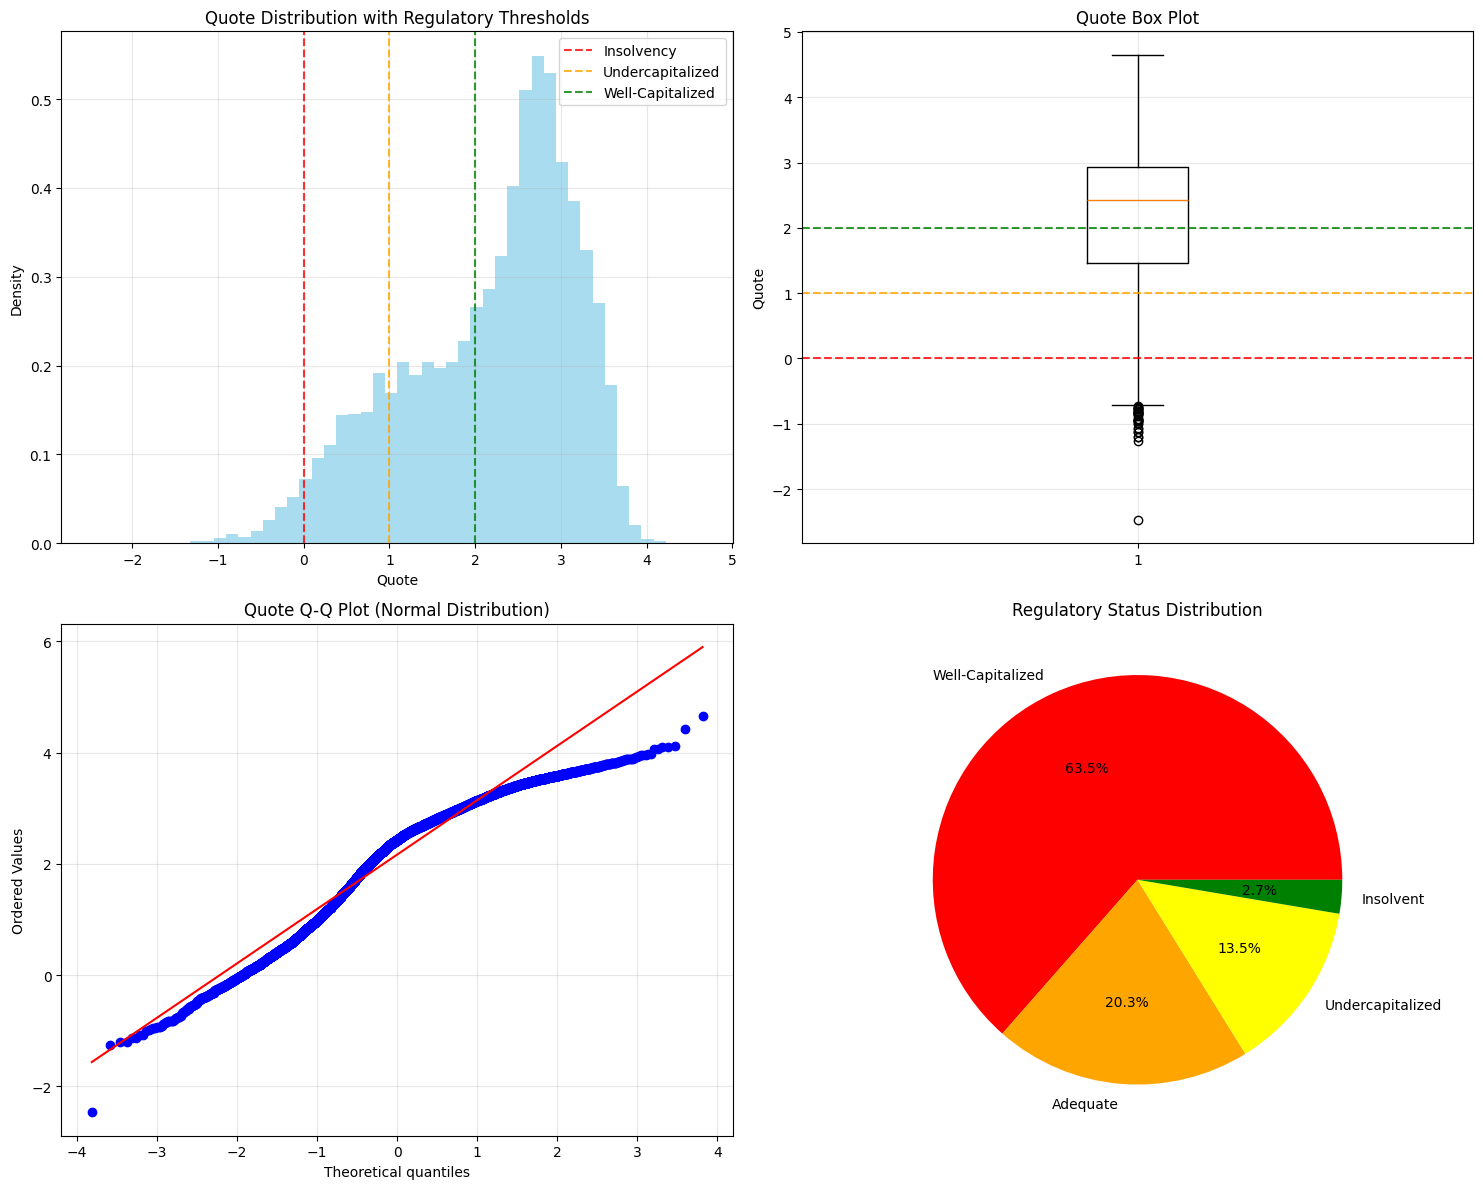

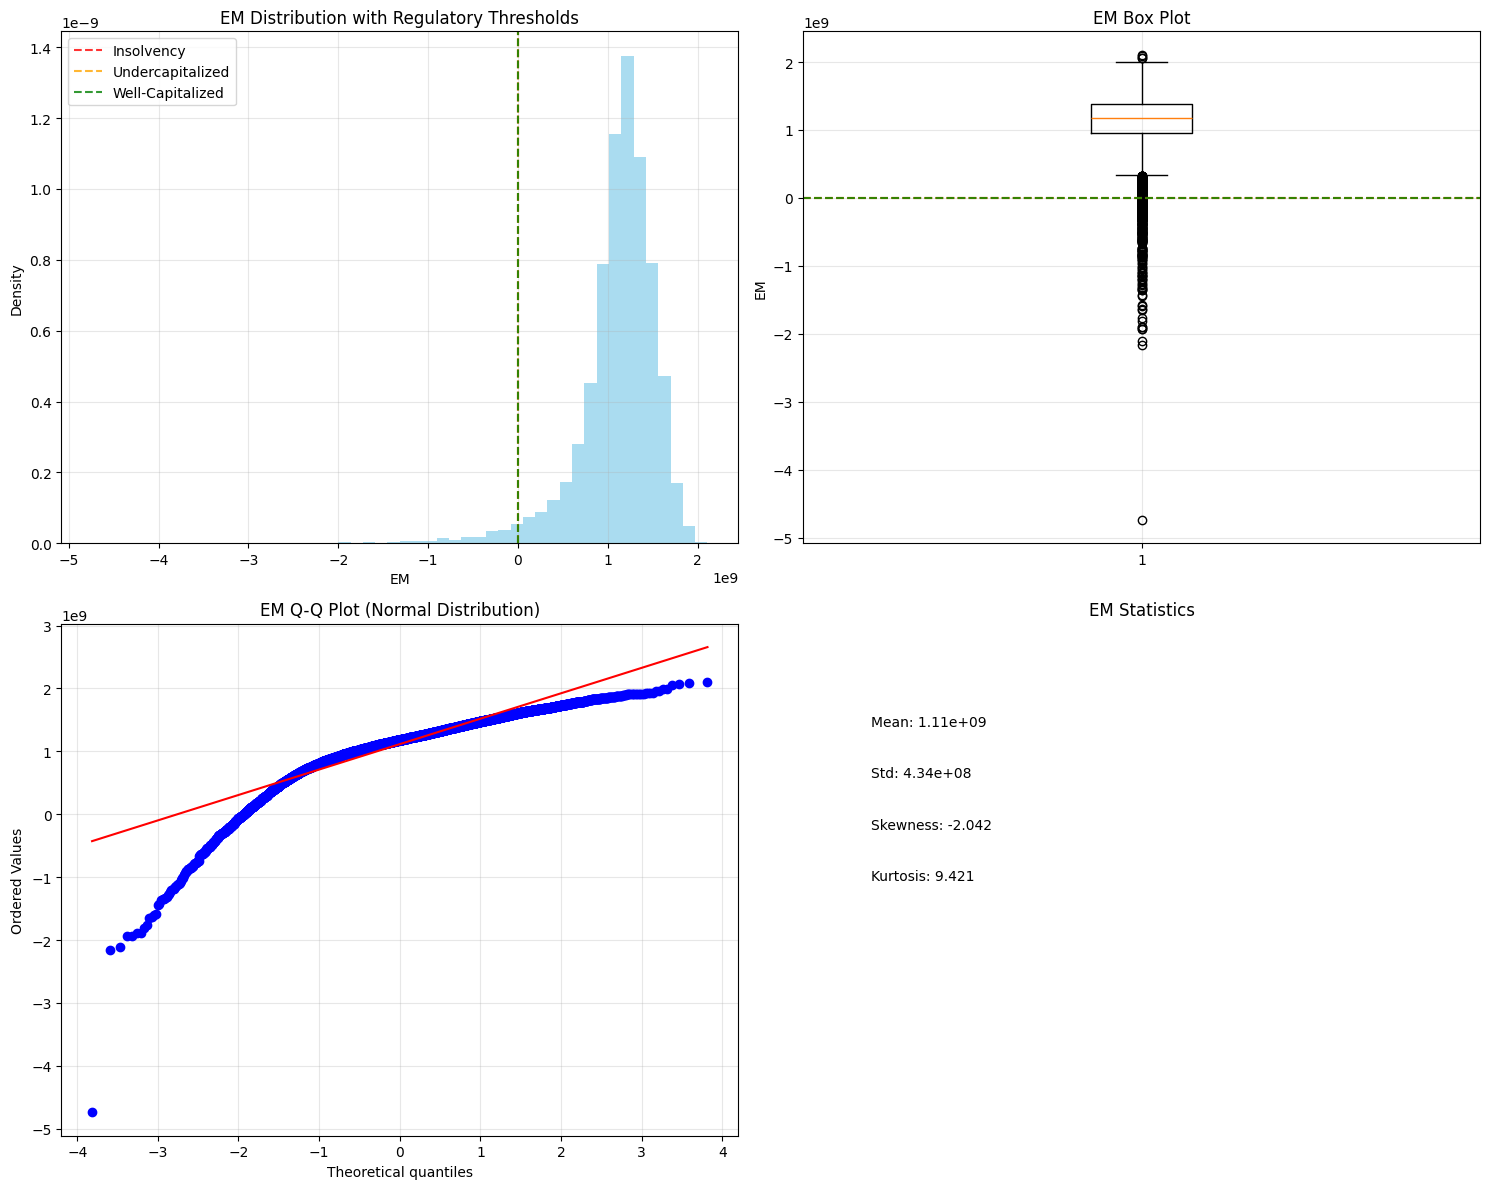

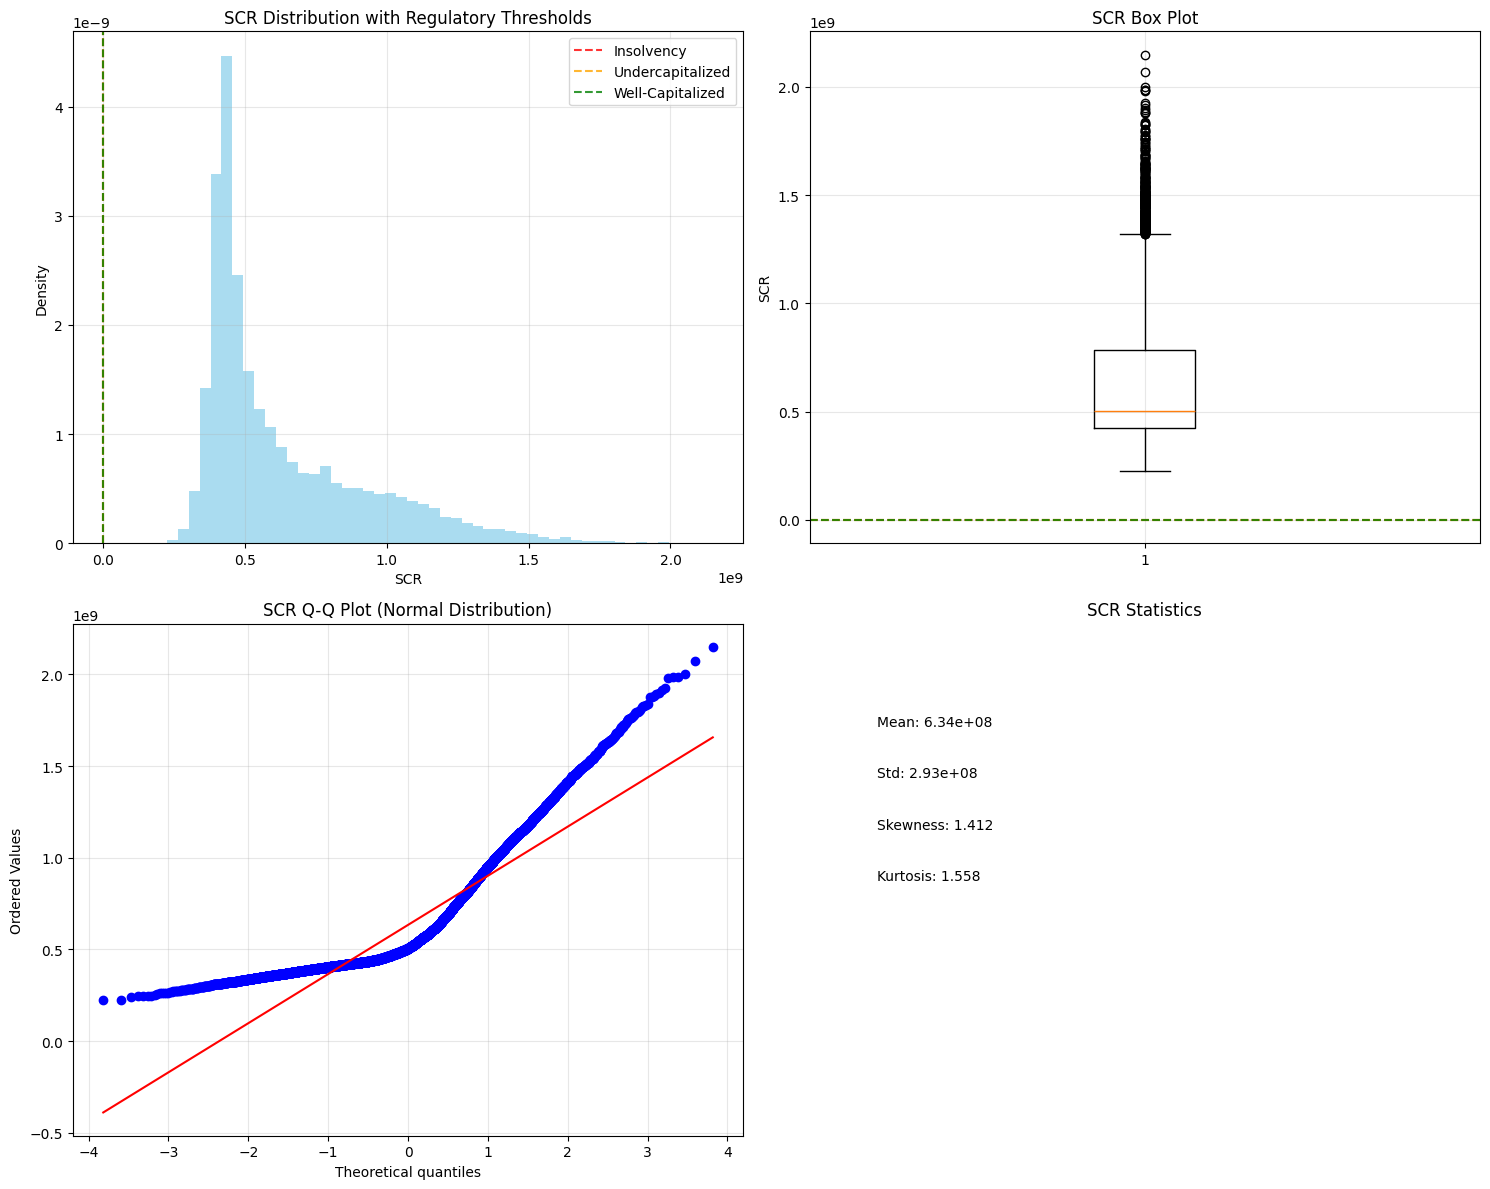

In [14]:
# Create regulatory threshold indicators for enhanced analysis
df['regulatory_status'] = pd.cut(df['Quote'], 
                                bins=[-np.inf, 0, 1, 2, np.inf], 
                                labels=['Insolvent', 'Undercapitalized', 'Adequate', 'Well-Capitalized'])

df['is_insolvent'] = (df['Quote'] < 0).astype(int)
df['is_undercapitalized'] = (df['Quote'] < 1).astype(int)
df['is_well_capitalized'] = (df['Quote'] > 2).astype(int)

# Create distribution analysis plots
print(f"\nCreating target distribution analysis...")
os.makedirs("figs", exist_ok=True)
for target in ['Quote', 'EM', 'SCR']:
    fig = plot_distribution_analysis(df, target)
    fig_path = os.path.join("figs", f"distribution_analysis_{target.lower()}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    # plt.close(fig) 

# SECTION 2: Data preprocessing and splitting

In [15]:
# Set random seeds for reproducibility
RANDOM_STATE = 8
np.random.seed(RANDOM_STATE)

# Extract features and targets
X = df[feature_cols].copy()
y_quote = df['Quote'].copy()
y_scr = df['SCR'].copy()
y_em = df['EM'].copy()
y_multi = df[['SCR', 'EM']].copy()

print(f"Features shape: {X.shape}")
print(f"Primary target (Quote) shape: {y_quote.shape}")
print(f"Multi-target (SCR, EM) shape: {y_multi.shape}")

# Split data: Train (60%), Validation (20%), Test (20%)
X_temp, X_test, y_quote_temp, y_quote_test = train_test_split(
    X, y_quote, test_size=0.2, random_state=RANDOM_STATE
)

X_train, X_val, y_quote_train, y_quote_val = train_test_split(
    X_temp, y_quote_temp, test_size=0.25, random_state=RANDOM_STATE
)

# Split other targets accordingly
_, y_scr_test = train_test_split(y_scr, test_size=0.2, random_state=RANDOM_STATE)
_, y_em_test = train_test_split(y_em, test_size=0.2, random_state=RANDOM_STATE)
_, y_multi_test = train_test_split(y_multi, test_size=0.2, random_state=RANDOM_STATE)

y_scr_temp, _ = train_test_split(y_scr, test_size=0.2, random_state=RANDOM_STATE)
y_em_temp, _ = train_test_split(y_em, test_size=0.2, random_state=RANDOM_STATE)
y_multi_temp, _ = train_test_split(y_multi, test_size=0.2, random_state=RANDOM_STATE)

y_scr_train, y_scr_val = train_test_split(y_scr_temp, test_size=0.25, random_state=RANDOM_STATE)
y_em_train, y_em_val = train_test_split(y_em_temp, test_size=0.25, random_state=RANDOM_STATE)
y_multi_train, y_multi_val = train_test_split(y_multi_temp, test_size=0.25, random_state=RANDOM_STATE)

print(f"\nData splits:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

# Create preprocessing pipeline (fit only on training data) + standarize
numeric_features = feature_cols
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

print(f"\nPreprocessing pipeline created with {len(numeric_features)} numeric features")

Features shape: (10230, 20)
Primary target (Quote) shape: (10230,)
Multi-target (SCR, EM) shape: (10230, 2)

Data splits:
Train: 6138 samples (60.0%)
Validation: 2046 samples (20.0%)
Test: 2046 samples (20.0%)

Preprocessing pipeline created with 20 numeric features


# SECTION 3: Models

## SECTION 3.1: Model Definitions

In [16]:
# Models with different complexity levels and loss functions
models_config = {
    'dummy': {
        'name': 'Dummy Regressor',
        'model': DummyRegressor(strategy='mean'),
        'loss': 'MSE'
    },
    'linear_mse': {
        'name': 'Linear Regression (MSE)',
        'model': LinearRegression(),
        'loss': 'MSE'
    },
    'linear_mae': {
        'name': 'Linear Regression (MAE)',
        'model': LinearRegression(),  # sklearn LinearRegression always uses MSE
        'loss': 'MAE'
    },
    'ridge_cv': {
        'name': 'Ridge with CV',
        'model': RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5),
        'loss': 'MSE'
    },
    'lasso_cv': {
        'name': 'Lasso with CV', 
        'model': LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, random_state=RANDOM_STATE),
        'loss': 'MSE'
    },
    # 'quadratic': {
    #     'name': 'Quadratic (Degree 2)',
    #     'model': Pipeline([
    #         ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    #         ('ridge', Ridge(alpha=1.0, random_state=RANDOM_STATE))
    #     ]),
    #     'loss': 'MSE'
    # },
    # 'cubic': {
    #     'name': 'Cubic (Degree 3)',
    #     'model': Pipeline([
    #         ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    #         ('ridge', Ridge(alpha=10.0, random_state=RANDOM_STATE))
    #     ]),
    #     'loss': 'MSE'
    # },
    'quadratic': {
    'name': 'Quadratic (Degree 2)',
    'model': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('ridge', Ridge(alpha=100.0, random_state=RANDOM_STATE))  
    ]),
    'loss': 'MSE'
    },
    'cubic': {
        'name': 'Cubic (Degree 3)', 
        'model': Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('ridge', Ridge(alpha=1000.0, random_state=RANDOM_STATE))
        ]),
        'loss': 'MSE'
    },
    # 'elastic_net': {
    #     'name': 'Elastic Net',
    #     'model': ElasticNet(random_state=RANDOM_STATE),
    #     'loss': 'MSE',
    #     'param_grid': {
    #         'alpha': [0.01, 0.1, 1.0, 10.0],
    #         'l1_ratio': [0.1, 0.5, 0.7, 0.9]
    #     }
    # }
    'elastic_net': {
    'name': 'Elastic Net',
    'model': ElasticNet(random_state=RANDOM_STATE),
    'loss': 'MSE',
    'param_grid': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Wider range
        'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]  # More options
        }
    },
    'ridge_cv': {
        'name': 'Ridge with CV',
        'model': RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5),
        'loss': 'MSE'
    },
    'lasso_cv': {
        'name': 'Lasso with CV', 
        'model': LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, random_state=RANDOM_STATE),
        'loss': 'MSE'
    }
}

print(f"Defined {len(models_config)} model configurations:")
for key, config in models_config.items():
    print(f"  - {config['name']} (Loss: {config['loss']})")


Defined 8 model configurations:
  - Dummy Regressor (Loss: MSE)
  - Linear Regression (MSE) (Loss: MSE)
  - Linear Regression (MAE) (Loss: MAE)
  - Ridge with CV (Loss: MSE)
  - Lasso with CV (Loss: MSE)
  - Quadratic (Degree 2) (Loss: MSE)
  - Cubic (Degree 3) (Loss: MSE)
  - Elastic Net (Loss: MSE)


## SECTION 3.2: Model Training & Eval Functions

In [17]:
def train_and_evaluate_model(model_config, X_train, X_val, X_test, y_train, y_val, y_test, 
                            preprocessor, target_name, cv_folds=5):
    """Train and evaluate a single model with comprehensive metrics"""
    
    model_name = model_config['name']
    base_model = model_config['model']
    
    print(f"\nTraining {model_name} for {target_name}...")
    
    # Create full pipeline
    if 'param_grid' in model_config:
        # Hyperparameter tuning for Elastic Net
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', base_model)
        ])
        
        param_grid = {f'model__{k}': v for k, v in model_config['param_grid'].items()}
        
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv_folds, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        final_model = grid_search.best_estimator_
        
        print(f"  Best parameters: {grid_search.best_params_}")
        
    else:
        # Standard training
        final_model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', base_model)
        ])
        final_model.fit(X_train, y_train)
    
    # Cross-validation on training data
    cv_scores = cross_val_score(final_model, X_train, y_train, 
                            cv=cv_folds, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    # Predictions
    y_train_pred = final_model.predict(X_train)
    y_val_pred = final_model.predict(X_val)
    y_test_pred = final_model.predict(X_test)
    
    # Calculate metrics for all splits
    train_metrics = calculate_all_metrics(y_train, y_train_pred, "train_")
    val_metrics = calculate_all_metrics(y_val, y_val_pred, "val_")
    test_metrics = calculate_all_metrics(y_test, y_test_pred, "test_")
    
    # Combine all metrics
    all_metrics = {
        **train_metrics,
        **val_metrics, 
        **test_metrics,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std()
    }
    
    # Add regulatory performance analysis for Quote predictions
    if target_name == 'Quote':
        print(f"\n  Regulatory Performance Analysis for {model_name}:")
        
        # Validation set regulatory analysis
        val_reg_results = analyze_regulatory_performance(y_val, y_val_pred, f"{model_name} - Validation")
        
        # Test set regulatory analysis  
        test_reg_results = analyze_regulatory_performance(y_test, y_test_pred, f"{model_name} - Test")
        
        # Store regulatory results
        all_metrics['regulatory_val'] = val_reg_results
        all_metrics['regulatory_test'] = test_reg_results
    
    results = {
        'model': final_model,
        'model_name': model_name,
        'target_name': target_name,
        'metrics': all_metrics,
        'predictions': {
            'train': y_train_pred,
            'val': y_val_pred,
            'test': y_test_pred
        },
        'actuals': {
            'train': y_train,
            'val': y_val,
            'test': y_test
        }
    }
    
    return results

def train_multioutput_model(model_config, X_train, X_val, X_test, y_train, y_val, y_test, 
                        preprocessor, cv_folds=5):
    """Train and evaluate multi-output model for SCR and EM simultaneously"""
    
    model_name = model_config['name'] + ' (Multi-Output)'
    base_model = model_config['model']
    
    print(f"\nTraining {model_name}...")
    
    # Create multi-output pipeline
    if 'param_grid' in model_config:
        # For Elastic Net with hyperparameter tuning
        multi_model = MultiOutputRegressor(base_model)
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', multi_model)
        ])
        
        param_grid = {f'model__estimator__{k}': v for k, v in model_config['param_grid'].items()}
        
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv_folds, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        final_model = grid_search.best_estimator_
        
    else:
        # Standard multi-output training
        multi_model = MultiOutputRegressor(base_model)
        final_model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', multi_model)
        ])
        final_model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = final_model.predict(X_train)
    y_val_pred = final_model.predict(X_val)
    y_test_pred = final_model.predict(X_test)
    
    # Calculate metrics for each target separately
    target_names = ['SCR', 'EM']
    all_metrics = {}
    
    for i, target in enumerate(target_names):
        train_metrics = calculate_all_metrics(y_train.iloc[:, i], y_train_pred[:, i], f"train_{target}_")
        val_metrics = calculate_all_metrics(y_val.iloc[:, i], y_val_pred[:, i], f"val_{target}_")
        test_metrics = calculate_all_metrics(y_test.iloc[:, i], y_test_pred[:, i], f"test_{target}_")
        
        all_metrics.update({**train_metrics, **val_metrics, **test_metrics})
    
    # Calculate macro-averaged metrics
    train_rmse_macro = np.mean([all_metrics[f'train_{t}_RMSE'] for t in target_names])
    val_rmse_macro = np.mean([all_metrics[f'val_{t}_RMSE'] for t in target_names])
    test_rmse_macro = np.mean([all_metrics[f'test_{t}_RMSE'] for t in target_names])
    
    all_metrics.update({
        'train_RMSE_macro': train_rmse_macro,
        'val_RMSE_macro': val_rmse_macro,
        'test_RMSE_macro': test_rmse_macro
    })
    
    results = {
        'model': final_model,
        'model_name': model_name,
        'target_name': 'SCR_EM_Multi',
        'metrics': all_metrics,
        'predictions': {
            'train': y_train_pred,
            'val': y_val_pred,
            'test': y_test_pred
        },
        'actuals': {
            'train': y_train,
            'val': y_val,
            'test': y_test
        }
    }
    
    return results

In [18]:
all_results = {}

# Train models for Quote (primary target)
print("\nTRAINING MODELS FOR QUOTE (PRIMARY TARGET)")
all_results['quote'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test, 
            y_quote_train, y_quote_val, y_quote_test,
            preprocessor, "Quote"
        )
        all_results['quote'][model_key] = results
        
        # Print summary metrics
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE: {metrics['val_RMSE']:.4f}")
        print(f"    Test RMSE: {metrics['test_RMSE']:.4f}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train models for SCR (secondary target)
print("\nTRAINING MODELS FOR SCR (SECONDARY TARGET)")
all_results['scr'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test,
            y_scr_train, y_scr_val, y_scr_test,
            preprocessor, "SCR"
        )
        all_results['scr'][model_key] = results
        
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE: {metrics['val_RMSE']:.4f}")
        print(f"    Test RMSE: {metrics['test_RMSE']:.4f}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train models for EM (secondary target)
print("\nTRAINING MODELS FOR EM (SECONDARY TARGET)")
all_results['em'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test,
            y_em_train, y_em_val, y_em_test,
            preprocessor, "EM"
        )
        all_results['em'][model_key] = results
        
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE: {metrics['val_RMSE']:.4f}")
        print(f"    Test RMSE: {metrics['test_RMSE']:.4f}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train multi-output models for SCR and EM
print("\nTRAINING MULTI-OUTPUT MODELS FOR SCR & EM")
all_results['multi_output'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_multioutput_model(
            model_config, X_train, X_val, X_test,
            y_multi_train, y_multi_val, y_multi_test,
            preprocessor
        )
        all_results['multi_output'][model_key] = results
        
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    Val RMSE (SCR): {metrics['val_SCR_RMSE']:.4f}")
        print(f"    Val RMSE (EM): {metrics['val_EM_RMSE']:.4f}")
        print(f"    Val RMSE (Macro): {metrics['val_RMSE_macro']:.4f}")
        
    except Exception as e:
        print(f"  Error training multi-output {model_config['name']}: {str(e)}")



TRAINING MODELS FOR QUOTE (PRIMARY TARGET)

Training Dummy Regressor for Quote...

  Regulatory Performance Analysis for Dummy Regressor:

REGULATORY PERFORMANCE ANALYSIS - Dummy Regressor - Validation

Insolvent (61 obs, 3.0%):
  RMSE: 2.5066
  MAE: 2.4891
  R²: -71.0268

Undercapitalized (273 obs, 13.3%):
  RMSE: 1.5990
  MAE: 1.5763
  R²: -34.5268

Adequate (418 obs, 20.4%):
  RMSE: 0.7034
  MAE: 0.6387
  R²: -4.6981

Well-Capitalized (1294 obs, 63.2%):
  RMSE: 0.7770
  MAE: 0.6565
  R²: -2.2303

REGULATORY PERFORMANCE ANALYSIS - Dummy Regressor - Test

Insolvent (57 obs, 2.8%):
  RMSE: 2.4627
  MAE: 2.4474
  R²: -80.1726

Undercapitalized (271 obs, 13.2%):
  RMSE: 1.6237
  MAE: 1.5988
  R²: -31.8478

Adequate (422 obs, 20.6%):
  RMSE: 0.7052
  MAE: 0.6476
  R²: -5.3804

Well-Capitalized (1296 obs, 63.3%):
  RMSE: 0.7900
  MAE: 0.6718
  R²: -2.2994
  Dummy Regressor:
    CV RMSE: 1.0040 (±0.0153)
    Val RMSE: 1.0057
    Test RMSE: 1.0080

Training Linear Regression (MSE) for Quote